In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retinal-image-dataset-of-infants-and-rop/infant_retinal_database_info.csv
/kaggle/input/retinal-image-dataset-of-infants-and-rop/infant_retinal_database_info.xlsx
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/019_M_GA35_BW3050_PA46_DG11_PF0_D1_S03_3.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/164_F_GA30_BW1490_PA32_DG0_PF0_D3_S01_2.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/120_M_GA31_BW1670_PA39_DG0_PF0_D2_S03_15.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/138_F_GA26_BW680_PA35_DG3_PF2_D2_S03_5.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/093_M_GA31_BW1590_PA34_DG0_PF0_D2_S01_1.jpg
/kaggle/input/retinal-image

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


2025-09-24 08:44:28.954448: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
DATA_DIR = '/kaggle/input/retinal-image-dataset-of-infants-and-rop'

In [25]:
print("Dataset structure:")
for root, dirs, files in os.walk(DATA_DIR):
    level = root.replace(DATA_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show only first 5 files per folder
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

Dataset structure:
retinal-image-dataset-of-infants-and-rop/
  infant_retinal_database_info.csv
  infant_retinal_database_info.xlsx
  images_stack_without_captions/
    images_stack_without_captions/
      019_M_GA35_BW3050_PA46_DG11_PF0_D1_S03_3.jpg
      164_F_GA30_BW1490_PA32_DG0_PF0_D3_S01_2.jpg
      120_M_GA31_BW1670_PA39_DG0_PF0_D2_S03_15.jpg
      138_F_GA26_BW680_PA35_DG3_PF2_D2_S03_5.jpg
      093_M_GA31_BW1590_PA34_DG0_PF0_D2_S01_1.jpg
      ... and 5999 more files
  images/
    images/
      135/
        02/
          135_F_GA28_BW1170_PA34_DG2_PF0_D2_S02_6.jpg
          135_F_GA28_BW1170_PA34_DG2_PF0_D2_S02_5.jpg
          135_F_GA28_BW1170_PA34_DG2_PF0_D2_S02_4.jpg
          135_F_GA28_BW1170_PA34_DG2_PF0_D2_S02_12.jpg
          135_F_GA28_BW1170_PA34_DG2_PF0_D2_S02_8.jpg
          ... and 7 more files
        04/
          135_F_GA28_BW1170_PA40_DG9_PF0_D2_S04_5.jpg
          135_F_GA28_BW1170_PA40_DG9_PF0_D2_S04_11.jpg
          135_F_GA28_BW1170_PA40_DG9_PF0_D2_S04_8.j

In [26]:
#  Load and Explorng Metadata
metadata_path = os.path.join(DATA_DIR, 'infant_retinal_database_info.csv')
df_meta = pd.read_csv(metadata_path)

print("Metadata shape:", df_meta.shape)
print("\nMetadata columns:")
print(df_meta.columns.tolist())
print("\nFirst few rows:")
print(df_meta.head())


Metadata shape: (484, 1)

Metadata columns:
['ID;SEX;GESTATIONAL AGE (GA);BIRTH WEIGHT (BW);POSTCONCEPTUAL AGE (PA);DIAGNOSIS CODE (DG);PLUS FORM (PF);DEVICE (D);SERIE NUMBER (S)']

First few rows:
  ID;SEX;GESTATIONAL AGE (GA);BIRTH WEIGHT (BW);POSTCONCEPTUAL AGE (PA);DIAGNOSIS CODE (DG);PLUS FORM (PF);DEVICE (D);SERIE NUMBER (S)
0                            1;F;41;2905;44;11;0;1;1                                                                                  
1                            1;F;41;2905;47;11;0;1;2                                                                                  
2                            1;F;41;2905;50;11;0;1;3                                                                                  
3                            2;M;40;4040;41;11;0;1;1                                                                                  
4                            2;M;40;4040;43;11;0;1;2                                                                           

In [32]:
# Explore Image Folders
images_dir = os.path.join(DATA_DIR, '/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions')
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total images in dataset: {len(image_files)}")
print("\nSample image filenames:")
for i, filename in enumerate(image_files[:10]):
    print(f"{i+1}: {filename}")


Total images in dataset: 6004

Sample image filenames:
1: 019_M_GA35_BW3050_PA46_DG11_PF0_D1_S03_3.jpg
2: 164_F_GA30_BW1490_PA32_DG0_PF0_D3_S01_2.jpg
3: 120_M_GA31_BW1670_PA39_DG0_PF0_D2_S03_15.jpg
4: 138_F_GA26_BW680_PA35_DG3_PF2_D2_S03_5.jpg
5: 093_M_GA31_BW1590_PA34_DG0_PF0_D2_S01_1.jpg
6: 058_M_GA30_BW1490_PA33_DG0_PF0_D1_S01_5.jpg
7: 184_F_GA29_BW1230_PA38_DG0_PF0_D3_S01_9.jpg
8: 089_M_GA41_BW3500_PA41_DG11_PF0_D2_S01_3.jpg
9: 012_M_GA36_BW2210_PA41_DG11_PF0_D1_S02_7.jpg
10: 096_F_GA31_BW2000_PA41_DG0_PF0_D2_S04_3.jpg


In [29]:
#  Parse Image Filenames for Labels
def parse_filename(filename):
    """
    Parse filename to extract patient information
    Format: PatientID_Sex_GA##_BW####_PA##_DG#_PF#_Device_Series_ImageNum.jpg
    """
    try:
        base_name = filename.split('.')[0]
        parts = base_name.split('_')
        
        info = {}
        info['patient_id'] = parts[0]
        info['sex'] = parts[1]
        
        # Extract numeric values
        for part in parts:
            if part.startswith('GA'):
                info['gestational_age'] = int(part[2:])
            elif part.startswith('BW'):
                info['birth_weight'] = int(part[2:])
            elif part.startswith('PA'):
                info['postconceptual_age'] = int(part[2:])
            elif part.startswith('DG'):
                info['diagnosis'] = int(part[2:])
            elif part.startswith('PF'):
                info['plus_form'] = int(part[2:])
        
        return info
    except:
        return None

# Test parsing on sample files
print("Testing filename parsing:")
for filename in image_files[:5]:
    parsed = parse_filename(filename)
    print(f"{filename}: {parsed}")


Testing filename parsing:
019_M_GA35_BW3050_PA46_DG11_PF0_D1_S03_3.jpg: {'patient_id': '019', 'sex': 'M', 'gestational_age': 35, 'birth_weight': 3050, 'postconceptual_age': 46, 'diagnosis': 11, 'plus_form': 0}
164_F_GA30_BW1490_PA32_DG0_PF0_D3_S01_2.jpg: {'patient_id': '164', 'sex': 'F', 'gestational_age': 30, 'birth_weight': 1490, 'postconceptual_age': 32, 'diagnosis': 0, 'plus_form': 0}
120_M_GA31_BW1670_PA39_DG0_PF0_D2_S03_15.jpg: {'patient_id': '120', 'sex': 'M', 'gestational_age': 31, 'birth_weight': 1670, 'postconceptual_age': 39, 'diagnosis': 0, 'plus_form': 0}
138_F_GA26_BW680_PA35_DG3_PF2_D2_S03_5.jpg: {'patient_id': '138', 'sex': 'F', 'gestational_age': 26, 'birth_weight': 680, 'postconceptual_age': 35, 'diagnosis': 3, 'plus_form': 2}
093_M_GA31_BW1590_PA34_DG0_PF0_D2_S01_1.jpg: {'patient_id': '093', 'sex': 'M', 'gestational_age': 31, 'birth_weight': 1590, 'postconceptual_age': 34, 'diagnosis': 0, 'plus_form': 0}


In [30]:
#create DF
image_data = []
for filename in image_files:
    parsed = parse_filename(filename)
    if parsed:
        parsed['filename'] = filename
        parsed['filepath'] = os.path.join(images_dir, filename)
        image_data.append(parsed)

df_images = pd.DataFrame(image_data)
print(f"Successfully parsed {len(df_images)} images")
print("\nDataset distribution by diagnosis:")
print(df_images['diagnosis'].value_counts().sort_index())

Successfully parsed 6004 images

Dataset distribution by diagnosis:
diagnosis
0     2980
1       45
2      252
3      458
4      125
8      470
9      379
10      72
11    1061
12      48
13     114
Name: count, dtype: int64


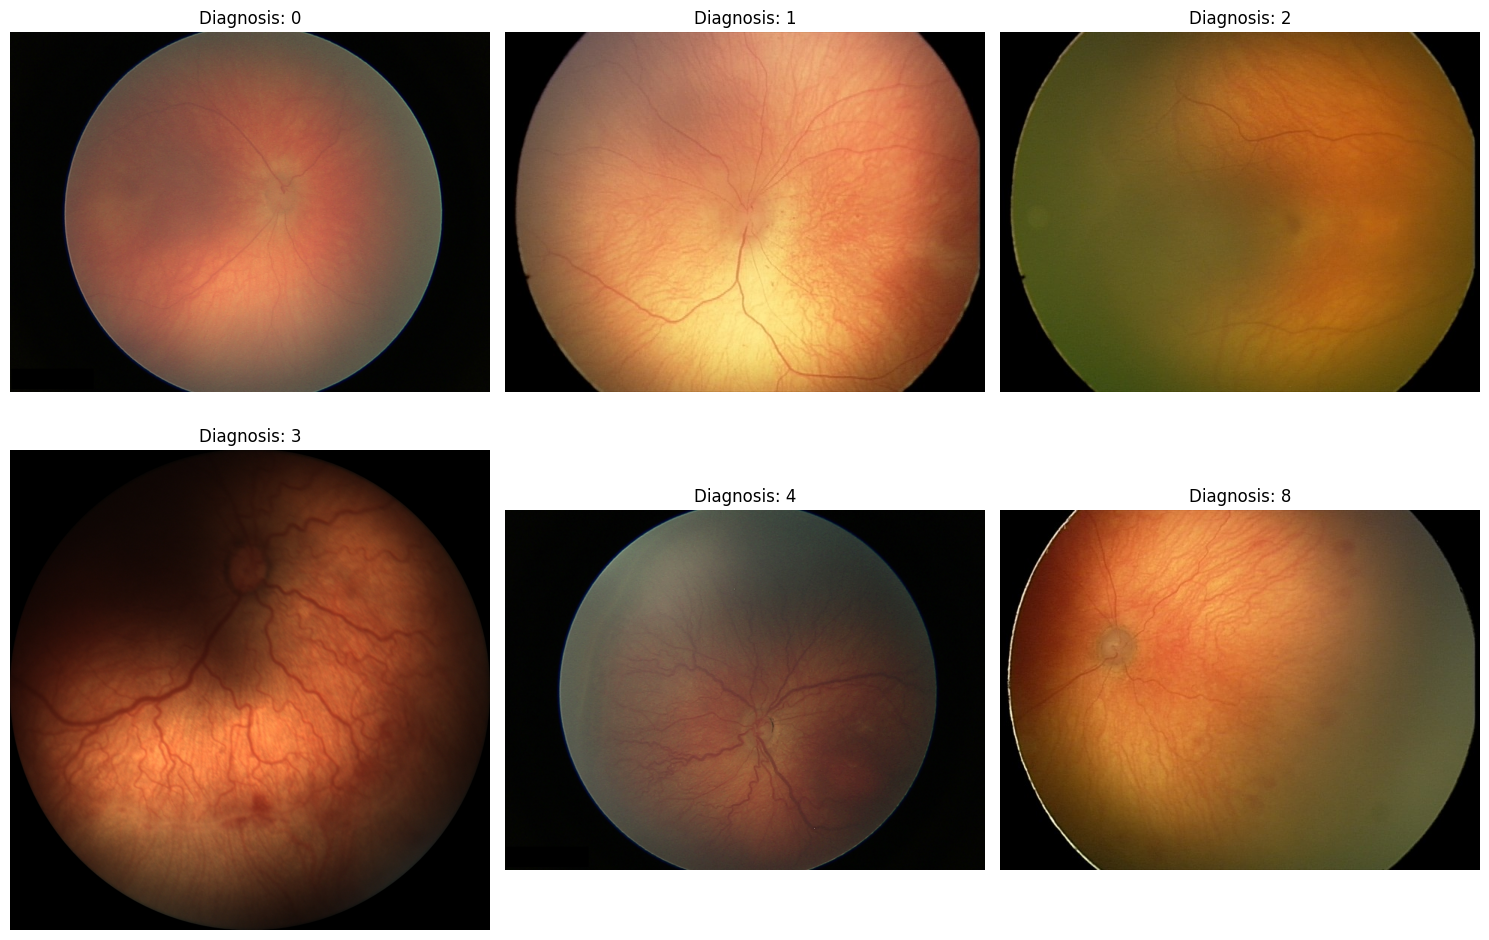

In [33]:
#  Display Sample Images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Show one image from each diagnosis class
for i, diagnosis in enumerate(sorted(df_images['diagnosis'].unique())[:6]):
    sample_img_path = df_images[df_images['diagnosis'] == diagnosis].iloc[0]['filepath']
    
    # Load and display image
    img = cv2.imread(sample_img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'Diagnosis: {diagnosis}')
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [34]:
#preprocess function
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess retinal image
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return None
            
        # Convert color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Normalize pixel values
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Test preprocessing on a sample image
sample_path = df_images.iloc[0]['filepath']
processed_img = preprocess_image(sample_path)
if processed_img is not None:
    print(f"Processed image shape: {processed_img.shape}")
    print(f"Pixel value range: {processed_img.min():.3f} - {processed_img.max():.3f}")

Processed image shape: (224, 224, 3)
Pixel value range: 0.000 - 0.996


In [35]:
print("Loading and preprocessing images...")
X = []
y = []

for idx, row in df_images.iterrows():
    img = preprocess_image(row['filepath'])
    if img is not None:
        X.append(img)
        y.append(row['diagnosis'])
    
    if (idx + 1) % 1000 == 0:
        print(f"Processed {idx + 1}/{len(df_images)} images")

X = np.array(X)
y = np.array(y)

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")
print(f"Diagnosis distribution: {np.bincount(y)}")

Loading and preprocessing images...
Processed 1000/6004 images
Processed 2000/6004 images
Processed 3000/6004 images
Processed 4000/6004 images
Processed 5000/6004 images
Processed 6000/6004 images

Final dataset shape: X=(6004, 224, 224, 3), y=(6004,)
Diagnosis distribution: [2980   45  252  458  125    0    0    0  470  379   72 1061   48  114]


In [37]:
# Cell 10: Train-Test Split and Label Encoding (FIXED)
from tensorflow.keras.utils import to_categorical

print("Original diagnosis values:", sorted(np.unique(y)))

# Create a mapping from original diagnosis codes to zero-indexed labels
unique_diagnoses = sorted(np.unique(y))
diagnosis_to_label = {diag: idx for idx, diag in enumerate(unique_diagnoses)}
label_to_diagnosis = {idx: diag for idx, diag in enumerate(unique_diagnoses)}

print("Diagnosis mapping:")
for orig, new in diagnosis_to_label.items():
    print(f"Diagnosis {orig} -> Label {new}")

# Remap y to zero-indexed labels
y_remapped = np.array([diagnosis_to_label[diag] for diag in y])

print(f"Remapped labels range: {y_remapped.min()} to {y_remapped.max()}")

# Convert labels to categorical
num_classes = len(unique_diagnoses)
y_categorical = to_categorical(y_remapped, num_classes=num_classes)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, 
    test_size=0.2, 
    stratify=y_remapped, 
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Number of classes: {num_classes}")

# Save the mapping for later use in predictions
print("\nClass mapping saved for reference:")
for i in range(num_classes):
    print(f"Class {i}: Diagnosis {label_to_diagnosis[i]}")


Original diagnosis values: [0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13]
Diagnosis mapping:
Diagnosis 0 -> Label 0
Diagnosis 1 -> Label 1
Diagnosis 2 -> Label 2
Diagnosis 3 -> Label 3
Diagnosis 4 -> Label 4
Diagnosis 8 -> Label 5
Diagnosis 9 -> Label 6
Diagnosis 10 -> Label 7
Diagnosis 11 -> Label 8
Diagnosis 12 -> Label 9
Diagnosis 13 -> Label 10
Remapped labels range: 0 to 10
Training set: (4803, 224, 224, 3)
Validation set: (1201, 224, 224, 3)
Number of classes: 11

Class mapping saved for reference:
Class 0: Diagnosis 0
Class 1: Diagnosis 1
Class 2: Diagnosis 2
Class 3: Diagnosis 3
Class 4: Diagnosis 4
Class 5: Diagnosis 8
Class 6: Diagnosis 9
Class 7: Diagnosis 10
Class 8: Diagnosis 11
Class 9: Diagnosis 12
Class 10: Diagnosis 13


In [38]:
#  Data Augmentation Setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

print("Data augmentation configured for training")
print("Validation data will use original images without augmentation")


Data augmentation configured for training
Validation data will use original images without augmentation


In [39]:
#Model architecture with efficientNETB0
def create_rop_model(num_classes, input_shape=(224, 224, 3)):
    """
    Create ROP classification model using EfficientNetB0 with transfer learning
    """
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_rop_model(num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,411,822 (16.83 MB)

 Trainable params: 362,251 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [40]:
#  Training Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau,
    CSVLogger
)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_rop_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('training_history.csv')
]

print("Training callbacks configured:")
print("- Early stopping on validation loss")
print("- Model checkpoint saving best weights")
print("- Learning rate reduction on plateau")
print("- Training history logging")


Training callbacks configured:
- Early stopping on validation loss
- Model checkpoint saving best weights
- Learning rate reduction on plateau
- Training history logging


In [41]:
#  Initial Training (Transfer Learning Phase 1)
print("Starting Phase 1: Training with frozen base model...")

# Train the model
history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("Phase 1 training completed!")


Starting Phase 1: Training with frozen base model...
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4698 - loss: 1.7972 - precision: 0.4793 - recall: 0.1865
Epoch 1: val_accuracy improved from -inf to 0.49625, saving model to best_rop_model.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.4699 - loss: 1.7969 - precision: 0.4793 - recall: 0.1864 - val_accuracy: 0.4963 - val_loss: 1.6751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
  1/150 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.5312 - loss: 1.5154 - precision: 0.6364 - recall: 0.2188
Epoch 2: val_accuracy did not improve from 0.49625
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - accuracy: 0.5312 - loss: 1.5154 - precision: 0.6364 - recall: 0.2188 - val_accuracy: 0.4963 - val_loss: 1.6782 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4966 - loss: 1.7309 - precision:

In [42]:
#optimizing my hardware
# Cell 11a: Hardware Detection and Configuration
import tensorflow as tf
from tensorflow.keras import mixed_precision

def configure_hardware():
    """
    Configure GPU/TPU usage and mixed precision for optimal performance
    """
    print("=" * 60)
    print("HARDWARE CONFIGURATION")
    print("=" * 60)
    
    # Check available devices
    physical_devices = tf.config.list_physical_devices()
    print("Available devices:")
    for device in physical_devices:
        print(f"  {device}")
    
    # Configure GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth to avoid allocating all GPU memory at once
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"\n Found {len(gpus)} GPU(s). Memory growth enabled.")
            
            # Print GPU details
            for i, gpu in enumerate(gpus):
                gpu_details = tf.config.experimental.get_device_details(gpu)
                print(f"  GPU {i}: {gpu_details.get('device_name', 'Unknown')}")
                
        except RuntimeError as e:
            print(f" GPU configuration error: {e}")
    else:
        print("  No GPU found. Using CPU.")
    
    # Check for TPU
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f" TPU detected: {tpu.cluster_spec().as_dict()}")
        return strategy, 'TPU'
    except ValueError:
        print(" No TPU found.")
        
        # Use GPU strategy if available
        if gpus:
            if len(gpus) > 1:
                strategy = tf.distribute.MirroredStrategy()
                print(f" Using MirroredStrategy with {len(gpus)} GPUs")
            else:
                strategy = tf.distribute.get_strategy()  # Default strategy
                print(" Using single GPU strategy")
        else:
            strategy = tf.distribute.get_strategy()  # Default strategy
            print(" Using CPU strategy")
        
        return strategy, 'GPU' if gpus else 'CPU'

def configure_mixed_precision(device_type):
    """
    Configure mixed precision training based on available hardware
    """
    print("\n" + "=" * 60)
    print("MIXED PRECISION CONFIGURATION")
    print("=" * 60)
    
    if device_type == 'TPU':
        # Use bfloat16 for TPUs
        policy = mixed_precision.Policy('mixed_bfloat16')
        mixed_precision.set_global_policy(policy)
        print(" Mixed precision enabled: mixed_bfloat16 (TPU optimized)")
        return 'mixed_bfloat16'
    
    elif device_type == 'GPU':
        # Check GPU compute capability
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                gpu_details = tf.config.experimental.get_device_details(gpus[0])
                compute_capability = gpu_details.get('compute_capability')
                
                if compute_capability and compute_capability >= (7, 0):
                    # Use float16 for modern GPUs (Volta and newer)
                    policy = mixed_precision.Policy('mixed_float16')
                    mixed_precision.set_global_policy(policy)
                    print(f" Mixed precision enabled: mixed_float16")
                    print(f"   GPU compute capability: {compute_capability}")
                    return 'mixed_float16'
                else:
                    print(f" GPU compute capability {compute_capability} < 7.0")
                    print("   Mixed precision not recommended for this GPU")
                    return None
            except:
                print("  Could not determine GPU compute capability")
                print("   Trying mixed precision anyway...")
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
                return 'mixed_float16'
    else:
        print("  Mixed precision not available for CPU training")
        return None

# Configure hardware and mixed precision
strategy, device_type = configure_hardware()
precision_policy = configure_mixed_precision(device_type)

# Set optimal batch sizes based on hardware
if device_type == 'TPU':
    BATCH_SIZE = 128  # TPUs work best with larger batch sizes
    VAL_BATCH_SIZE = 128
elif device_type == 'GPU' and precision_policy:
    BATCH_SIZE = 64   # Doubled due to mixed precision memory savings
    VAL_BATCH_SIZE = 64
else:
    BATCH_SIZE = 32   # Conservative batch size for CPU or older GPUs
    VAL_BATCH_SIZE = 32

print(f"\n Configured batch sizes: Train={BATCH_SIZE}, Validation={VAL_BATCH_SIZE}")
print("=" * 60)


HARDWARE CONFIGURATION
Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  No GPU found. Using CPU.
 No TPU found.
 Using CPU strategy

MIXED PRECISION CONFIGURATION
  Mixed precision not available for CPU training

 Configured batch sizes: Train=32, Validation=32


In [44]:
# Cell 15: Fine-tuning (Transfer Learning Phase 2)
print("Starting Phase 2: Fine-tuning with unfrozen layers...")

# Unfreeze the base model for fine-tuning
model.layers[0].trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Reset callbacks for phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_rop_model_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 fine-tuning completed!")


Starting Phase 2: Fine-tuning with unfrozen layers...
Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4730 - loss: 1.8189 - precision: 0.5208 - recall: 0.1901
Epoch 1: val_accuracy improved from -inf to 0.49625, saving model to best_rop_model_finetuned.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.4730 - loss: 1.8186 - precision: 0.5208 - recall: 0.1901 - val_accuracy: 0.4963 - val_loss: 1.6427 - val_precision: 0.7081 - val_recall: 0.1091 - learning_rate: 1.0000e-04
Epoch 2/15
  1/300 ━━━━━━━━━━━━━━━━━━━━ 10:47 2s/step - accuracy: 0.6875 - loss: 1.3284 - precision: 0.7500 - recall: 0.3750
Epoch 2: val_accuracy did not improve from 0.49625
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6875 - loss: 1.3284 - precision: 0.7500 - recall: 0.3750 - val_accuracy: 0.4963 - val_loss: 1.6413 - val_precision: 0.7075 - val_recall: 0.1249 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5026 - loss: 1.6502 - precis

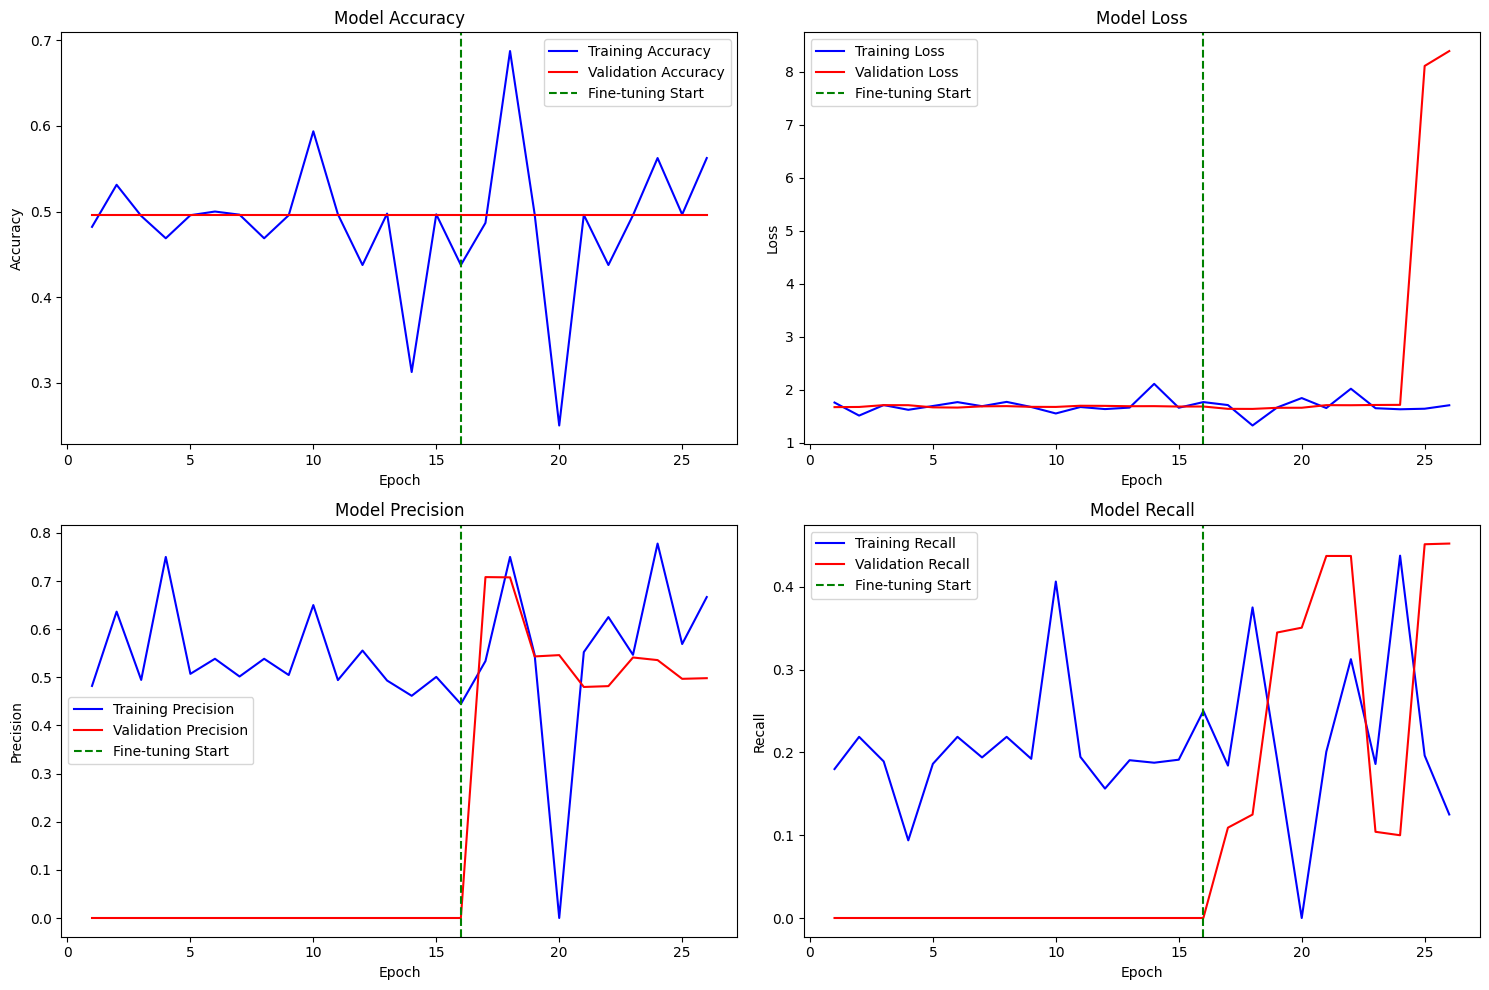

In [45]:
# Cell 16: Training History Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Combine histories
all_acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
all_val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
all_loss = history_phase1.history['loss'] + history_phase2.history['loss']
all_val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

epochs_total = range(1, len(all_acc) + 1)
phase1_epochs = len(history_phase1.history['accuracy'])

# Accuracy plot
axes[0,0].plot(epochs_total, all_acc, 'b-', label='Training Accuracy')
axes[0,0].plot(epochs_total, all_val_acc, 'r-', label='Validation Accuracy')
axes[0,0].axvline(x=phase1_epochs, color='green', linestyle='--', label='Fine-tuning Start')
axes[0,0].set_title('Model Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()

# Loss plot
axes[0,1].plot(epochs_total, all_loss, 'b-', label='Training Loss')
axes[0,1].plot(epochs_total, all_val_loss, 'r-', label='Validation Loss')
axes[0,1].axvline(x=phase1_epochs, color='green', linestyle='--', label='Fine-tuning Start')
axes[0,1].set_title('Model Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()

# Precision plot
if 'precision' in history_phase1.history:
    all_prec = history_phase1.history['precision'] + history_phase2.history['precision']
    all_val_prec = history_phase1.history['val_precision'] + history_phase2.history['val_precision']
    axes[1,0].plot(epochs_total, all_prec, 'b-', label='Training Precision')
    axes[1,0].plot(epochs_total, all_val_prec, 'r-', label='Validation Precision')
    axes[1,0].axvline(x=phase1_epochs, color='green', linestyle='--', label='Fine-tuning Start')
    axes[1,0].set_title('Model Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()

# Recall plot
if 'recall' in history_phase1.history:
    all_recall = history_phase1.history['recall'] + history_phase2.history['recall']
    all_val_recall = history_phase1.history['val_recall'] + history_phase2.history['val_recall']
    axes[1,1].plot(epochs_total, all_recall, 'b-', label='Training Recall')
    axes[1,1].plot(epochs_total, all_val_recall, 'r-', label='Validation Recall')
    axes[1,1].axvline(x=phase1_epochs, color='green', linestyle='--', label='Fine-tuning Start')
    axes[1,1].set_title('Model Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step 
Classification Report:
              precision    recall  f1-score   support

 Diagnosis 0       0.50      1.00      0.66       596
 Diagnosis 1       0.00      0.00      0.00         9
 Diagnosis 2       0.00      0.00      0.00        50
 Diagnosis 3       0.00      0.00      0.00        92
 Diagnosis 4       0.00      0.00      0.00        25
 Diagnosis 8       0.00      0.00      0.00        94
 Diagnosis 9       0.00      0.00      0.00        76
Diagnosis 10       0.00      0.00      0.00        14
Diagnosis 11       0.00      0.00      0.00       212
Diagnosis 12       0.00      0.00      0.00        10
Diagnosis 13       0.00      0.00      0.00        23

    accuracy                           0.50      1201
   macro avg       0.05      0.09      0.06      1201
weighted avg       0.25      0.50      0.33      1201



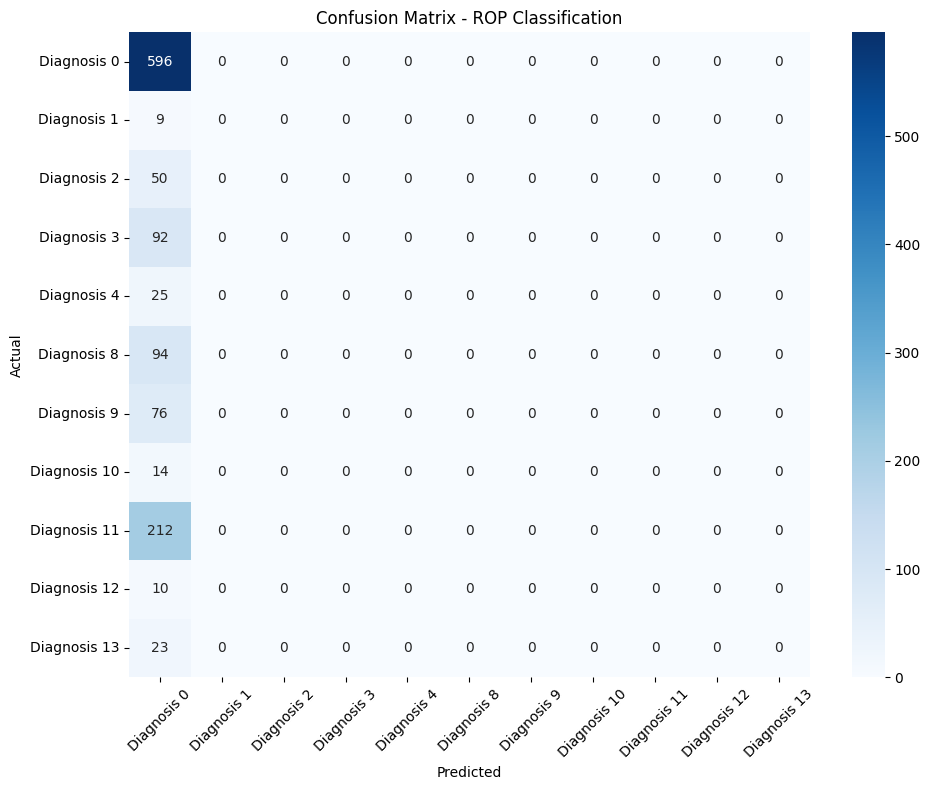


Per-class Accuracy:
Diagnosis 0: 1.000
Diagnosis 1: 0.000
Diagnosis 2: 0.000
Diagnosis 3: 0.000
Diagnosis 4: 0.000
Diagnosis 8: 0.000
Diagnosis 9: 0.000
Diagnosis 10: 0.000
Diagnosis 11: 0.000
Diagnosis 12: 0.000
Diagnosis 13: 0.000


In [46]:
# Cell 17: Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report:")
print("=" * 50)
target_names = [f"Diagnosis {label_to_diagnosis[i]}" for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - ROP Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class Accuracy:")
print("=" * 30)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f"Diagnosis {label_to_diagnosis[i]}: {acc:.3f}")
